# Analysis starting conditions of muons in ROI
In this notebook, we try to characterize the muons that reach the ROI (x,y in +-700, z in +-845) and compare them with the MUSUN conditions.

Just a recap of the muon data available:
- CJ simulated `2M` muons in LAr with MUSUN conditions
- `85069` of them present at least one entry in LAr (_the whole volume_)
- `20751` of them present at least one entry in the ROI (_active LAr, within Radon Shroud_)
- Among these `20K` events is ROI, `16K` present at least a non-zero detection, `4K` are undetected at all. Considering these `16K` muons with non-zero detection, we perform a cut on energy and apply ML on the low-energy ones (`~6K`).

In [1]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 20})

In [2]:
def load_dataframe_from_files(dirin, fileprefix):
    import glob
    files = glob.glob(os.path.join(dirin, fileprefix))
    columns = ["eventnumber", "energydeposition",  "detectionefficiency", "muonenergy", "muonx", "muony", "muonz", "muonpx", "muonpy", "muonpz"]
    print("[Info] Loading {}".format(files[0]))
    df = pd.read_csv(os.path.join(dirin, files[0]), comment='#', index_col=False)
    df = df[columns]
    for file in files[1:]:
        print("[Info] Loading {}".format(file))
        dftmp = pd.read_csv(os.path.join(dirin, file), comment='#', index_col=False)
        # keep only meaningful fields
        dftmp = dftmp[columns]
        df = pd.concat([df, dftmp])
    return df


In [3]:
dirin = os.path.join("..", "..", "Data", "musun")
filename = "musun1000000.dat"
musun = pd.read_csv(os.path.join(dirin, filename), sep='\s\s+', engine='python',  names=["id", "mp_mn", "energyGeV", "x", "y", "z", "theta", "phi"])
musun = musun[["energyGeV", "x", "y", "z", "theta", "phi"]]

In [4]:
dirin = os.path.join("..", "..", "Data", "MuonsROI")
filepref = "roi_RndSeed123456789_part1_part*"
roi = load_dataframe_from_files(dirin, filepref)

[Info] Loading ../../Data/MuonsROI/roi_RndSeed123456789_part1_part1.csv
[Info] Loading ../../Data/MuonsROI/roi_RndSeed123456789_part1_part2.csv
[Info] Loading ../../Data/MuonsROI/roi_RndSeed123456789_part1_part3.csv
[Info] Loading ../../Data/MuonsROI/roi_RndSeed123456789_part1_part4.csv
[Info] Loading ../../Data/MuonsROI/roi_RndSeed123456789_part1_part5.csv
[Info] Loading ../../Data/MuonsROI/roi_RndSeed123456789_part1_part6.csv
[Info] Loading ../../Data/MuonsROI/roi_RndSeed123456789_part1_part7.csv


In [5]:
print("All Muon events (at least 1 entry) in ROI: {}".format(roi.eventnumber.nunique()))
print("Detected (PE>0) Muons in ROI: {}".format(roi[roi.energydeposition * roi.detectionefficiency > 0].eventnumber.nunique()))

All Muon events (at least 1 entry) in ROI: 20751
Detected (PE>0) Muons in ROI: 16274


In [15]:
roi["energyGeV"] = roi.muonenergy / 1000000 # convert from kev to gev
roi.energyGeV.describe()

count    1.560842e+07
mean     5.637103e+02
std      7.473302e+02
min      2.124040e-01
25%      1.346944e+02
50%      3.246944e+02
75%      7.117944e+02
max      3.130099e+04
Name: energyGeV, dtype: float64

In [16]:
# compute the starting condition for each muon wt >=1 entry in ROI
roi_events = roi.groupby("eventnumber").first()
# compute the starting condition for each muon wt >0 PE detected in ROI
roi_nonzero = roi[roi.energydeposition * roi.detectionefficiency > 0].groupby("eventnumber").first()


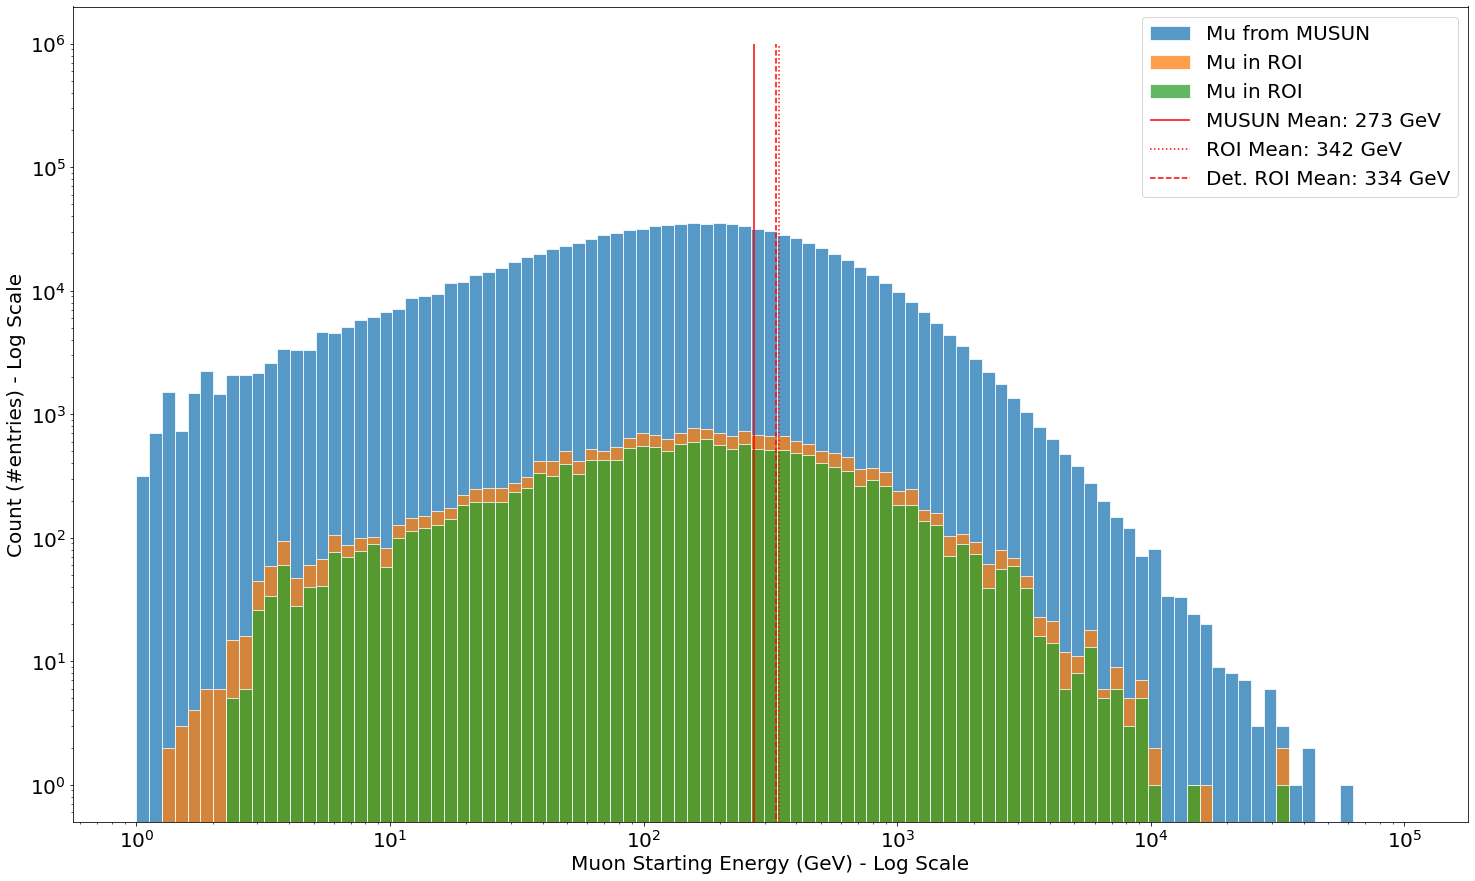

In [21]:
alpha = 0.75
bins = np.logspace(0, 5, 100)
plt.hist(musun.energyGeV, bins=bins, alpha=alpha, label="Mu from MUSUN", edgecolor='w')
plt.hist(roi_events.energyGeV, bins=bins, alpha=alpha, label="Mu in ROI", edgecolor='w')
plt.hist(roi_nonzero.energyGeV, bins=bins, alpha=alpha, label="Mu in ROI", edgecolor='w')
plt.vlines(musun.energyGeV.mean(), 0, 1000000, color='r', label="MUSUN Mean: {:.0f} GeV".format(musun.energyGeV.mean()))
plt.vlines(roi_events.energyGeV.mean(), 0, 1000000, color='r', linestyles='dotted', label="ROI Mean: {:.0f} GeV".format(roi_events.energyGeV.mean()))
plt.vlines(roi_nonzero.energyGeV.mean(), 0, 1000000, color='r', linestyles='dashed', label="Det. ROI Mean: {:.0f} GeV".format(roi_nonzero.energyGeV.mean()))
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Muon Starting Energy (GeV) - Log Scale")
plt.ylabel("Count (#entries) - Log Scale")
plt.legend()
plt.show()

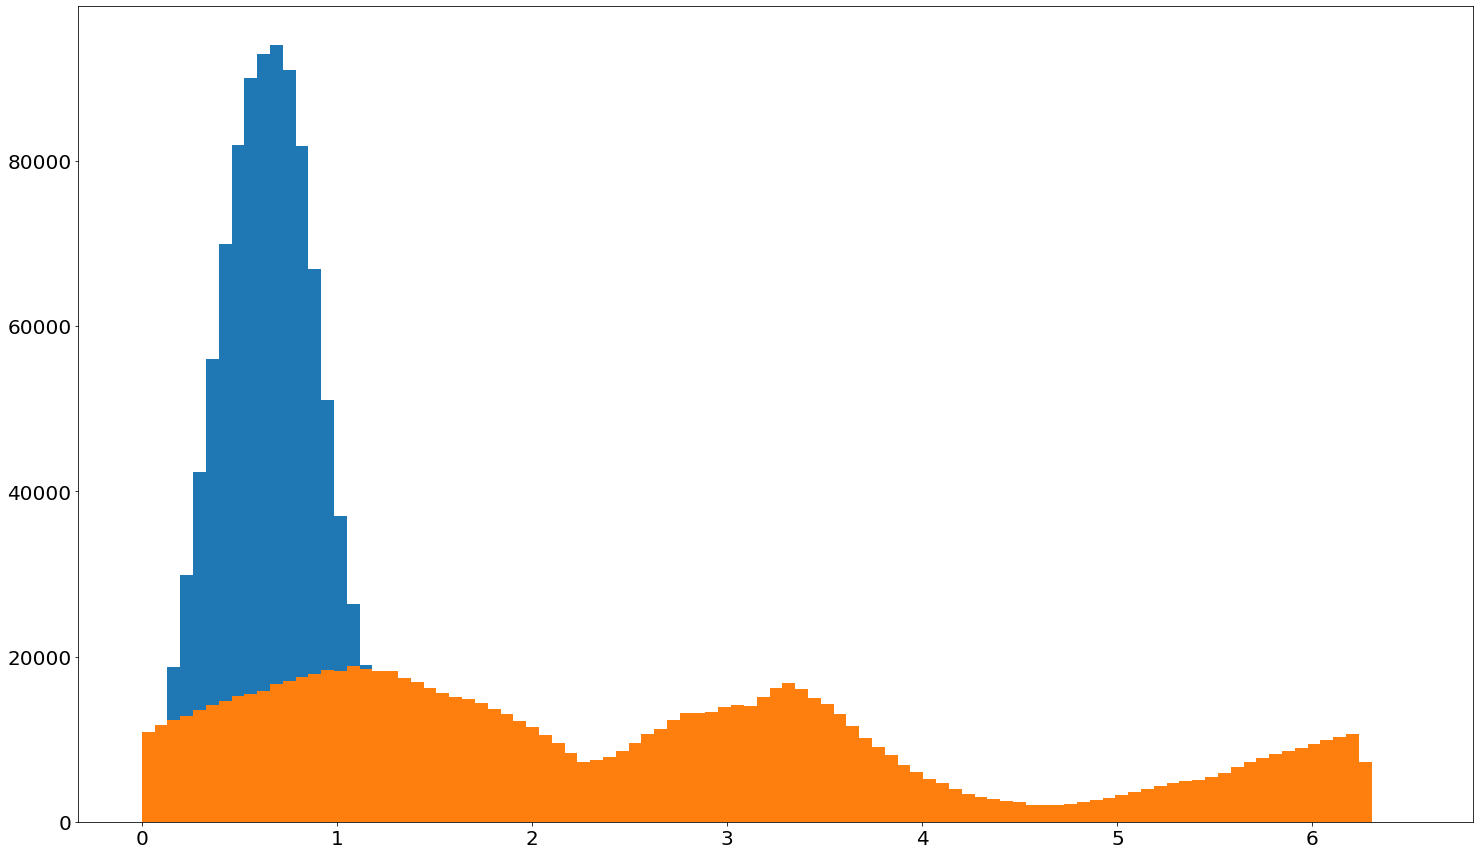

In [22]:
bins = np.linspace(0, 6.5, 100)
plt.hist(musun.theta, bins=bins, label="theta")
plt.hist(musun.phi, bins=bins, label="phi")
plt.show()

In [38]:
roi_events["pt"] = (roi_events.muonpx**2 + roi_events.muonpz**2)**0.5
roi_events["theta"] = np.arcsin(roi_events.muonpx / roi_events.pt)

In [39]:
roi_events.head()

,energydeposition,detectionefficiency,muonenergy,muonx,muony,muonz,muonpx,muonpy,muonpz,energyGeV,pt,theta
eventnumber,,,,,,,,,,,,
5,35488.673379,0.000656,1.999462e+07,-5044.499817,-5328.000488,9750.000000,8.666259e+06,8.739395e+06,-1.589116e+07,19.994620,1.810064e+07,0.499267
31,6840.892573,0.000000,4.359447e+07,9000.000000,-1725.000000,5790.000000,-3.781398e+07,4.835767e+06,-2.136371e+07,43.594470,4.343162e+07,-1.056534
88,5790.979301,0.000000,1.893944e+08,9000.000000,-4810.500183,7473.000488,-1.393220e+08,8.093880e+07,-9.974240e+07,189.394374,1.713452e+08,-0.949470
164,24408.579121,0.000000,2.720944e+08,273.000011,3490.499878,9750.000000,-2.236886e+07,-7.678033e+07,-2.601870e+08,272.094375,2.611468e+08,-0.085761
202,12805.459927,0.000000,1.483944e+08,-1847.999878,-5505.000000,9750.000000,2.572706e+07,6.291034e+07,-1.320328e+08,148.394383,1.345159e+08,0.192442


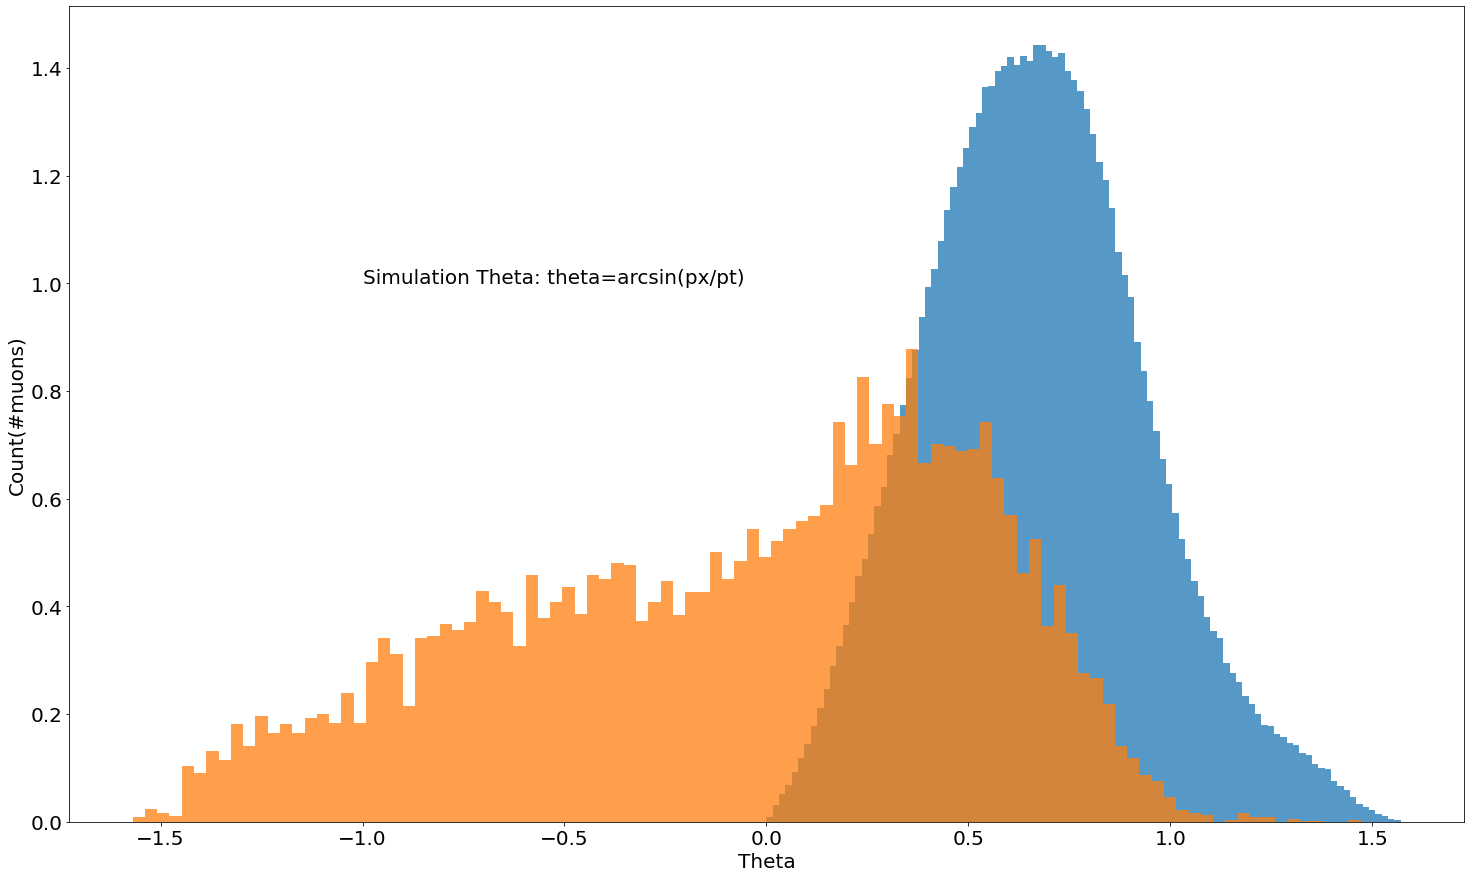

In [46]:
alpha=0.75
plt.hist(musun.theta,bins=100, density=True, label="MUSUN", alpha=alpha)
plt.hist(roi_events.theta,bins=100, density=True, label="Simulations", alpha=alpha)
plt.ylabel("Count(#muons)")
plt.xlabel("Theta")
plt.text(-1, 1, "Simulation Theta: theta=arcsin(px/pt)")
plt.show()

In [103]:
row0[["muonpx", "muonpz"]]

muonpx    8.666259e+06
muonpz   -1.589116e+07
Name: 5, dtype: float64

In [106]:
pt = (row0.muonpx**2+row0.muonpz**2)**0.5

In [107]:
row0.muonpx / pt 

0.47878201143674104

In [108]:
row0.muonpz / pt 

-0.8779338161413925

In [112]:
np.arcsin(row0.muonpx / pt) < np.pi/2

True

In [113]:
np.arccos(row0.muonpz / pt)< np.pi/2

False

In [10]:
px = musun.energyGeV * 1000000 * np.sin(musun.theta)

In [11]:
prova.describe()

count    1.000000e+06
mean     1.658134e+08
std      3.378828e+08
min      0.000000e+00
25%      2.565516e+07
50%      7.301817e+07
75%      1.821769e+08
max      5.406456e+10
dtype: float64

In [13]:
roi.muonpx.describe()

count    1.560842e+07
mean    -1.036319e+04
std      4.702339e+08
min     -8.984393e+09
25%     -1.142121e+08
50%      3.589768e+06
75%      1.049080e+08
max      1.906765e+10
Name: muonpx, dtype: float64

In [27]:
musun.head().to_csv("musun_head.csv")

In [30]:
roi_events.head()[["energyGeV", "muonx", "muony", "muonz", "muonpx", "muonpy", "muonpz"]].to_csv("simulated_muons.csv")